# procedural Video Captioning with Spatial Reinforcement Learing

# Team Members:
# Rounak Jain - 211IT055
# Sudarshan Zunja - 211IT072
# Verma Ayush - 211IT079

In [ ]:
#import modules
import tensorflow as tf
#os for handling the files
import os
import shutil
import subprocess
import glob
import cv2
#pickle for storing numpy features
import pickle
import numpy as np
#ui for representing how much data is processed
from tqdm.notebook import tqdm

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
#pad_sequences is used to pad in the length of a sentence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define directiories

In [ ]:
# List all video files in the youtubeclips folder
videos_folder = "/kaggle/input/msvd-clips/YouTubeClips"
temp_dest = "/kaggle/working/frames"
feat_dir = "/kaggle/input/features/feat_dir"  # Replace with your desired directory
video_dest = "/kaggle/input/msvd-clips"  # Replace with your actual path
img_dim = 224
channels = 3
frames_step = 80
batch_cnn = 32
# List all video files in the youtubeclips folder
video_files = os.listdir(videos_folder)

## Import Model

In [ ]:
model = VGG16(weights = "imagenet", include_top=True,input_shape = (img_dim,img_dim,channels))
out = model.layers[-2].output
model_final = Model(inputs=model.inputs,outputs=out)
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Prepocess the captions data

In [ ]:
import pandas as pd

In [ ]:
df= pd.read_csv('/kaggle/input/msvd-dataset-corpus/video_corpus.csv')
df.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
2,mv89psg6zh4,33,46,362812,unverified,11,Macedonian,папагал се бања
3,mv89psg6zh4,33,46,968828,unverified,84,German,Ein Wellensittich duscht unter einem Wasserhahn.
4,mv89psg6zh4,33,46,203142,unverified,14,Romanian,o pasare sta intr-o chiuveta.


In [ ]:
df.head(-1)

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
2,mv89psg6zh4,33,46,362812,unverified,11,Macedonian,папагал се бања
3,mv89psg6zh4,33,46,968828,unverified,84,German,Ein Wellensittich duscht unter einem Wasserhahn.
4,mv89psg6zh4,33,46,203142,unverified,14,Romanian,o pasare sta intr-o chiuveta.
...,...,...,...,...,...,...,...,...
122598,m7x8uIdg2XU,67,73,303815,unverified,73,English,the girls are mixing the milk
122599,m7x8uIdg2XU,67,73,309959,unverified,19,English,The lady added a cream sauce to the pasta.
122600,m7x8uIdg2XU,67,73,130040,unverified,27,English,women are cooking her kichen
122601,m7x8uIdg2XU,67,73,762891,unverified,18,English,The woman is pouring cream over the pasta.


In [ ]:
# Read the CSV file
text_path = '/kaggle/input/msvd-dataset-corpus/video_corpus.csv'
text_data = pd.read_csv(text_path, sep=',')

# Filter for English language
text_data = text_data[text_data['Language'] == 'English']
# Create the video path
text_data['video_path'] = text_data.apply(lambda row:
                                          row['VideoID']+'_'+str(int(row['Start']))+'_'+str(int(row['End']))+'.npy',
                                          axis=1)
# Map video path to full path
feat_path = '/kaggle/input/features/feat_dir'  # Replace with the actual path
text_data['video_path'] = text_data['video_path'].map(lambda x: os.path.join(feat_path, x))
# List files in feat_path directory
file_list = os.listdir(feat_path)
# Filter for existing video paths
text_data = text_data[text_data['video_path'].map(lambda x: os.path.exists(x))]
# for video_path in text_data['video_path']:
#     print(f"{video_path}: {os.path.exists(video_path)}")

#Filter for valid descriptions
text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]

#Get unique filenames
unique_filenames = sorted(text_data['video_path'].unique())

#Filter data based on unique filenames
data = text_data[text_data['video_path'].map(lambda x: x in unique_filenames)]

#Display the cleaned caption data
data.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...


In [ ]:
data.head(-1)

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,/kaggle/input/features/feat_dir/mv89psg6zh4_33...
...,...,...,...,...,...,...,...,...,...
122596,m7x8uIdg2XU,67,73,919506,unverified,41,English,the person is cooking the something,/kaggle/input/features/feat_dir/m7x8uIdg2XU_67...
122597,m7x8uIdg2XU,67,73,749155,unverified,61,English,Milk being poured to a bowl of pasta,/kaggle/input/features/feat_dir/m7x8uIdg2XU_67...
122598,m7x8uIdg2XU,67,73,303815,unverified,73,English,the girls are mixing the milk,/kaggle/input/features/feat_dir/m7x8uIdg2XU_67...
122599,m7x8uIdg2XU,67,73,309959,unverified,19,English,The lady added a cream sauce to the pasta.,/kaggle/input/features/feat_dir/m7x8uIdg2XU_67...


## Define train and test dataset

In [ ]:
test_frac = 0.2
indices = np.arange(len(data))

# Shuffle the indices randomly
np.random.shuffle(indices)

# Calculate the index to split the data into training and testing sets
train_indices_rec = int((1 - test_frac) * len(data))

# Split the indices into training and testing sets
indices_train = indices[:train_indices_rec]
indices_test = indices[train_indices_rec:]

# Use the indices to extract the corresponding rows from the dataset
data_train = data.iloc[indices_train]
data_test = data.iloc[indices_test]

# Reset the indices of the new DataFrames
data_train.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)

# Display the training and testing sets
data_train.head(), data_test.head()

(       VideoID  Start  End  WorkerID      Source  AnnotationTime Language  \
 0  Uc63MFVwfrs    355  372    760882       clean              27  English   
 1  Lt1JijkvSKk      0   10    309959       clean              21  English   
 2  Kqb-mmkEWqU      1    5    169072  unverified              22  English   
 3  YmXCfQm0_CA     68   75    707318       clean              14  English   
 4  YAud4eS3DoA     54   65    860525  unverified              62  English   
 
                           Description  \
 0          A man is slicing a potato.   
 1  The animal chewed on the fan pull.   
 2               A small guy is angry.   
 3           A man is carrying a tree.   
 4               a man is making bread   
 
                                           video_path  
 0  /kaggle/input/features/feat_dir/Uc63MFVwfrs_35...  
 1  /kaggle/input/features/feat_dir/Lt1JijkvSKk_0_...  
 2  /kaggle/input/features/feat_dir/Kqb-mmkEWqU_1_...  
 3  /kaggle/input/features/feat_dir/YmXCfQm0_CA_68..

In [ ]:
data_train.shape

(64639, 9)

In [ ]:
data_test.shape

(16160, 9)

## Creating a vocabulary

In [ ]:
# Assuming sentence_iterator is a list of sentences from the dataset
sentence_iterator = data['Description'].tolist()

word_counts = {}
sent_cnt = 0

for sent in sentence_iterator:
    sent_cnt += 1
    for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= 5]

idx2word = {}
idx2word[0] = '<pad>'
idx2word[1] = '<bos>'
idx2word[2] = '<eos>'
idx2word[3] = '<unk>'

word2idx = {}
word2idx['<pad>'] = 0
word2idx['<bos>'] = 1
word2idx['<eos>'] = 2
word2idx['<unk>'] = 3

for idx, w in enumerate(vocab):
    word2idx[w] = idx + 4
    idx2word[idx + 4] = w

word_counts['<pad>'] = sent_cnt
word_counts['<bos>'] = sent_cnt
word_counts['<eos>'] = sent_cnt
word_counts['<unk>'] = sent_cnt

# Display the created dictionaries
print("word2idx:", word2idx)
print("\nidx2word:", idx2word)

word2idx: {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3, 'a': 4, 'bird': 5, 'in': 6, 'sink': 7, 'keeps': 8, 'getting': 9, 'under': 10, 'the': 11, 'running': 12, 'water': 13, 'from': 14, 'faucet.': 15, 'is': 16, 'bathing': 17, 'sink.': 18, 'splashing': 19, 'around': 20, 'standing': 21, 'drinking': 22, 'that': 23, 'pouring': 24, 'out': 25, 'of': 26, 'faucet': 27, 'while': 28, 'stands': 29, 'below.': 30, 'playing': 31, 'with': 32, 'water.': 33, 'tap': 34, 'taking': 35, 'bath.': 36, 'shower': 37, 'showering': 38, 'bath': 39, 'parakeet': 40, 'gets': 41, 'having': 42, 'kitchen': 43, 'walks': 44, 'parrot': 45, 'inside': 46, 'wash': 47, 'basin.': 48, 'n': 49, '': 50, 'white': 51, 'took': 52, 'plane': 53, 'flying': 54, 'sky': 55, 'commercial': 56, 'flying.': 57, 'jet': 58, 'large': 59, 'through': 60, 'sky.': 61, 'passenger': 62, 'flies': 63, 'air.': 64, 'south': 65, 'african': 66, 'blue': 67, 'an': 68, 'aeroplane': 69, 'airplane': 70, 'clear': 71, 'flew': 72, 'soaring': 73, 'itself': 74, 'air

In [ ]:
data_train['VideoID']

0        Uc63MFVwfrs
1        Lt1JijkvSKk
2        Kqb-mmkEWqU
3        YmXCfQm0_CA
4        YAud4eS3DoA
            ...     
64634    toE0QYZzJKE
64635    ZK4W-2ifl6I
64636    x_8RiVI6rH8
64637    rwHT2SuNOi8
64638    5zkCnHUnoYY
Name: VideoID, Length: 64639, dtype: object

In [ ]:

import torch
import os

class ConfigS2VT:
    '''
    Hyperparameter settings for Sequence to Sequence, Video to text (S2VT) model.
    '''
    def __init__(self,model_name='s2vt'):
        self.model_name = model_name

        #Device configuration
        self.cuda_device_id = 1
        if torch.cuda.is_available():
            self.device = torch.device('cuda:'+str(self.cuda_device_id))
        else:
            self.device = torch.device('cpu')


        #Dataloader configuration
        self.dataset = 'msvd' # 'msvd' and 'msrvtt'
        self.batch_size = 100
        self.val_batch_size = 10
        self.opt_truncate_caption = True
        self.max_caption_length = 30
        self.frame_len = 28

        # Encoder-decoder related configuration
        self.appearance_feature_extractor = 'inceptionv4'
        self.decoder_type = 'lstm'
        self.appearance_input_size = 1536
        self.appearance_projected_size = 500
        self.embedding_size = 500 # word embedding size
        self.max_length = 15

        self.decoder_l1_input_size = self.appearance_projected_size
        self.decoder_l1_hidden_size = 1000
        self.decoder_l2_input_size = self.decoder_l1_hidden_size + self.embedding_size
        self.decoder_l2_hidden_size = 1000

        self.embed_dropout = 0.5
        self.rnn_l1_dropout = 0.4
        self.rnn_l2_dropout = 0.4

        self.opt_param_init = False   # manually sets parameter initialisation strategy
        self.beam_length = 5


        #Training configuration

        self.lr = 1e-4
        self.teacher_forcing_ratio = 1.0 #
        self.clip = 5 # clip the gradient to counter exploding gradient problem
        self.print_every = 400


        #Vocabulary configuration
        self.SOS_token = 1
        self.EOS_token = 2
        self.PAD_token = 0
        self.UNK_token = 3
        self.vocabulary_min_count = 5


In [ ]:
cfg=ConfigS2VT()

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms

import random
import itertools
import math
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import itertools

import numpy as np
import os
import copy

In [ ]:
class EncoderDecoder(nn.Module):

    def __init__(self,cfg,voc):
        super(EncoderDecoder, self).__init__()
        '''
        Encoder decoder model.
        Args:
        hidden_size : hidden memory size of LSTM/GRU
        output_size : output size. Its same as the vocabulary size.
        n_layers :

        '''

        # Keep for reference
        self.feat_len = cfg.frame_len
        self.caption_len = cfg.max_caption_length
        self.total_time_steps = self.feat_len + self.caption_len
        self.output_size = len(voc)
        self.rnn_l1_dropout = cfg.rnn_l1_dropout
        self.rnn_l2_dropout = cfg.rnn_l2_dropout
        self.decoder_type = cfg.decoder_type
        self.l1_hidden = cfg.decoder_l1_hidden_size
        self.l2_hidden = cfg.decoder_l2_hidden_size
        self.device = cfg.device
        self.cfg = cfg

        # Define layers
        self.encoding = nn.Linear(cfg.appearance_input_size,cfg.appearance_projected_size)
        self.embedding = nn.Embedding(len(voc), cfg.embedding_size)
        self.embedding_dropout = nn.Dropout(cfg.embed_dropout)
        if self.decoder_type == 'gru':
            self.rnn1 = nn.GRU(input_size=cfg.decoder_l1_input_size, hidden_size=cfg.decoder_l1_hidden_size,
                              num_layers=1, dropout=self.rnn_l1_dropout)

            self.rnn2 = nn.GRU(input_size=cfg.decoder_l2_input_size, hidden_size=cfg.decoder_l2_hidden_size,
                              num_layers=1, dropout=self.rnn_l2_dropout)
        else:
            self.rnn1 = nn.LSTM(input_size=cfg.decoder_l1_input_size, hidden_size=cfg.decoder_l1_hidden_size,
                           num_layers=1, dropout=self.rnn_l1_dropout)

            self.rnn2 = nn.LSTM(input_size=cfg.decoder_l2_input_size, hidden_size=cfg.decoder_l2_hidden_size,
                           num_layers=1, dropout=self.rnn_l2_dropout)

        self.out = nn.Linear(cfg.decoder_l2_hidden_size, self.output_size)


    def forward(self,feats,target=None,use_teacher_forcing=False,training=True):
        '''
        we run this one step (word) at a time

        feats - (attention_length,batch,annotation_vector_size)
        target - (time_step,batch)
        use_teacher_forcing - boolean value. False during inference.

        we run the first lstm layer at once.
        first half of 2nd layer we run at once.
        second half of second layer run through a loop to generate words.

        '''
        output = []
        feats = self.encoding(feats)
        if training:
            T = target.size()[0]
        else:
            T = self.cfg.max_length
        B, Ft = feats.size()[1], feats.size()[-1]
        pad_tensor = torch.zeros(T,B,Ft).to(self.device)
        feats = torch.cat([feats,pad_tensor]).to(self.device)

        if self.decoder_type=='lstm':
            h1,c1 = torch.zeros(1,B,self.l1_hidden).to(self.device), torch.zeros(1,B,self.l1_hidden).to(self.device)
            h2,c2 = torch.zeros(1,B,self.l2_hidden).to(self.device), torch.zeros(1,B,self.l2_hidden).to(self.device)
            out1,(h1,c1) = self.rnn1(feats,(h1,c1))
        else:
            h1 = torch.zeros(1,B,self.l1_hidden).to(self.device)
            h2 = torch.zeros(1,B,self.l2_hidden).to(self.device)
            out1,h1 = self.rnn1(feats,h1) #out1 : (28+T,B,h)


        #print('out1 shape :',out1.size())
        sos_input = torch.LongTensor([[self.cfg.SOS_token for _ in range(B)]]).to(self.device) #(1,B)

        if use_teacher_forcing:
            word_input = target[:-1] # (T-1,B)
            combined_input = torch.cat([sos_input,word_input])
            embedded = self.embedding(combined_input) # [i/p:(T,B)  o/p:(T,B,Emb)]
            dummy = torch.zeros(self.cfg.frame_len,B,self.cfg.embedding_size).to(self.device)
            embedded = torch.cat([dummy,embedded]) # (T+28,B,E)
            embedded = self.embedding_dropout(embedded)
            l1_output = torch.cat([out1,embedded],dim=2) # (28+T,B,h+E)
        else:
            #add only first 28 time steps.
            dummy = torch.zeros(self.cfg.frame_len,B,self.cfg.embedding_size).to(self.device) # (28,B,E)
            out_p1 = out1[:self.cfg.frame_len]
            l1_output = torch.cat([out_p1,dummy],dim=2) # (28,B,h+E) need to fix

        #pass 1st half one step. we don't really care about out2, only we care about is (h2,c2)/h2
        if self.decoder_type == 'lstm':
            out2,(h2,c2) = self.rnn2(l1_output[:self.cfg.frame_len],(h2,c2))
        else:
            out2,h2 = self.rnn2(l1_output[:self.cfg.frame_len],h2)

        #final decoding loop
        if use_teacher_forcing:
            for t in range(T):
                decoder_input = l1_output[self.cfg.frame_len+t].unsqueeze(0)
                if self.decoder_type == 'lstm':
                    decoder_output,(h2,c2) = self.rnn2(decoder_input,(h2,c2))
                else:
                    decoder_output,h2 = self.rnn2(decoder_input,h2)

                decoder_output = self.out(decoder_output).squeeze(0)
                decoder_output = F.softmax(decoder_output, dim = 1) #(100,num_words)
                # Teacher forcing: next input comes from ground truth(data distribution)
                output.append(decoder_output.unsqueeze(0))
        else:
            word_emb = self.embedding(sos_input)
            for t in range(T):

                decoder_input = torch.cat([out1[self.cfg.frame_len+t].unsqueeze(0),word_emb],dim=2) #(1,B,E),(1,B,h) -> (1,B,E+h)

                if self.decoder_type == 'lstm':
                    decoder_output, (h2,c2) = self.rnn2(decoder_input,(h2,c2))
                else:
                    decoder_output, h2 = self.rnn2(decoder_input,h2)
                decoder_output = self.out(decoder_output)
                decoder_output = F.softmax(decoder_output, dim = 1) #(100,num_words)

                # No teacher forcing: next input is decoder's own current output(model distribution)
                _, topi = decoder_output.squeeze(0).topk(1)
                decoder_input = torch.LongTensor([[topi[i][0] for i in range(B)]])
                decoder_input = decoder_input.to(self.device)
                word_emb = self.embedding(decoder_input)
                if training:
                    output.append(decoder_output)
                else:
                    output.append(topi.squeeze(1).cpu())

        output = torch.stack(output,0)

        return output

In [ ]:
encoder_decoder = EncoderDecoder(cfg, vocab)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
class S2VT(nn.Module):

    def __init__(self,voc,cfg,path):
        super(S2VT,self).__init__()

        self.voc = voc
        self.path = path
        self.cfg = cfg

        self.encoderdecoder = EncoderDecoder(cfg,voc).to(cfg.device)
        self.encdec_optimizer = optim.Adam(self.encoderdecoder.parameters(),lr=cfg.lr)

        self.teacher_forcing_ratio = cfg.teacher_forcing_ratio
        self.print_every = cfg.print_every
        self.clip = cfg.clip
        self.device = cfg.device
        if cfg.opt_param_init:
            self.init_params()


    def init_params(self):
        for name, param in self.encoderdecoder.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
                #nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')


    def update_hyperparameters(self,cfg):

        self.encdec_optimizer = optim.Adam(self.encoderdecoder.parameters(),lr=cfg.lr)
        self.teacher_forcing_ratio = cfg.teacher_forcing_ratio


    def load(self,encoder_path = 'Save/Meanpool_10.pt',decoder_path='Saved/SALSTM_10.pt'):
        if os.path.exists(encoder_path) and os.path.exists(decoder_path):
            self.encoder.load_state_dict(torch.load(encoder_path))
            self.decoder.load_state_dict(torch.load(decoder_path))
        else:
            print('File not found Error..')

    def save(self,encoder_path,decoder_path):
        if os.path.exists(encoder_path) and os.path.exists(decoder_path):

            torch.save(model.encoder.state_dict(),encoder_path)
            torch.save(model.decoder.state_dict(),decoder_path)
        else:
            print('Invalid path address given.')

    def train_epoch(self,dataloader,utils):
        '''
        Function to train the model for a single epoch.
        Args:
         Input:
            dataloader : the dataloader object.basically train dataloader object.
         Return:
             epoch_loss : Average single time step loss for an epoch
        '''
        total_loss = 0
        start_iteration = 1
        print_loss = 0
        iteration = 1

        self.encoderdecoder.train()
        for data in dataloader:
            features, targets, mask, max_length, _,_,_ = data
            use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
            loss = self.train_iter(utils,features,targets,mask,max_length,use_teacher_forcing)
            #print('Loss :',loss)
            print_loss += loss
            total_loss += loss
        # Print progress
            if iteration % self.print_every == 0:
                print_loss_avg = print_loss / self.print_every
                print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".
                format(iteration, iteration / len(dataloader) * 100, print_loss_avg))
                print_loss = 0


            iteration += 1
        return total_loss/len(dataloader)


    def train_iter(self,utils,input_variable, target_variable, mask,max_target_len,use_teacher_forcing):
        '''
        Forward propagate input signal and update model for a single iteration.

        Args:
        Inputs:
            input_variable : video mini-batch tensor; size = (B,T,F)
            target_variable : Ground Truth Captions;  size = (T,B); T will be different for different mini-batches
            mask : Masked tensor for Ground Truth;    size = (T,C)
            max_target_len : maximum lengh of the mini-batch; size = T
            use_teacher_forcing : binary variable. If True training uses teacher forcing else sampling.
            clip : clip the gradients to counter exploding gradient problem.
        Returns:
            iteration_loss : average loss per time step.
        '''

        self.encdec_optimizer.zero_grad()

        loss = 0
        print_losses = []
        n_totals = 0

        input_variable = input_variable.permute(1,0,2).to(self.device)

        input_variable = input_variable.to(self.device)
        target_variable = target_variable.to(self.device)
        mask = mask.byte().to(self.device)

        output = self.encoderdecoder(input_variable,target_variable,use_teacher_forcing)
        #print(output.size())

        # Loss calculation
        for t in range(max_target_len):
            mask_loss, nTotal = utils.maskNLLLoss(output[t], target_variable[t], mask[t],self.device)
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

        # Perform backpropatation
        loss.backward()

        _ = nn.utils.clip_grad_norm_(self.encoderdecoder.parameters(), self.clip)
        self.encdec_optimizer.step()

        return sum(print_losses) / n_totals


    @torch.no_grad()
    def GreedyDecoding(self,features,max_length=15):
        batch_size = features.size()[0]
        features = features.permute(1,0,2).to(self.device)

        caption = self.encoderdecoder(features,use_teacher_forcing=False,training=False).permute(1,0) #(T,B,V)
        caps_text = []
        for dta in caption:
            tmp = []
            for token in dta:
                if token.item() not in self.voc.index2word.keys() or token.item()==2: # Remove EOS and bypass OOV
                    pass
                else:
                    tmp.append(self.voc.index2word[token.item()])
            tmp = ' '.join(x for x in tmp)
            caps_text.append(tmp)
        return caption,caps_text,


In [ ]:
class Path:
    '''
    Currently supports MSVD and MSRVTT
    VATEX will be added in future
    '''
    def _init_(self,cfg,working_path):

        if cfg.dataset == 'msvd':
            self.local_path = os.path.join(working_path,'MSVD')
            self.video_path = 'path_to_raw_video_data' # For future use
            self.caption_path = os.path.join(self.local_path,'captions')
            self.feature_path = os.path.join(self.local_path,'features')

            self.name_mapping_file = os.path.join(self.caption_path,'youtube_mapping.txt')
            self.train_annotation_file = os.path.join(self.caption_path,'sents_train_lc_nopunc.txt')
            self.val_annotation_file = os.path.join(self.caption_path,'sents_val_lc_nopunc.txt')
            self.test_annotation_file = os.path.join(self.caption_path,'sents_test_lc_nopunc.txt')


            if cfg.appearance_feature_extractor == 'inceptionv4':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_INCEPTIONV4_28.hdf5')

            if cfg.appearance_feature_extractor == 'inceptionresnetv2':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_INCEPTIONRESNETV2_28.hdf5')

            if cfg.appearance_feature_extractor == 'resnet101':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_RESNET101_28.hdf5')

            if cfg.appearance_feature_extractor == 'resnet101hc':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_RESNET101_HC.hdf5')

            self.motion_feature_file = os.path.join(self.feature_path,'MSVD_MOTION_RESNEXT101.hdf5')
            #self.object_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_INCEPTIONV4.hdf5')


        if cfg.dataset == 'msrvtt':
            self.local_path = os.path.join(working_path,'MSRVTT')
            self.video_path = '/media/nasibullah/Ubuntu/DataSets/MSRVTT/'
            self.caption_path = os.path.join(self.local_path,'captions')
            self.feature_path = os.path.join(self.local_path,'features')

            self.category_file_path = os.path.join(self.caption_path,'category.txt')
            self.train_val_annotation_file = os.path.join(self.caption_path,'train_val_videodatainfo.json')
            self.test_annotation_file = os.path.join(self.caption_path,'test_videodatainfo.json')

            if cfg.appearance_feature_extractor == 'inceptionv4':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSRVTT_APPEARANCE_INCEPTIONV4_28.hdf5')

            if cfg.appearance_feature_extractor == 'inceptionresnetv2':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSRVTT_APPEARANCE_INCEPTIONRESNETV2_28.hdf5')

            if cfg.appearance_feature_extractor == 'resnet101':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSRVTT_APPEARANCE_RESNET101_28.hdf5')




            self.val_id_list = list(range(6513,7010))
            self.train_id_list = list(range(0,6513))
            self.test_id_list = list(range(7010,10000))

        self.prediction_path = 'results'
        self.saved_models_path = 'Saved'

In [ ]:
path = Path()
path

In [ ]:
model = S2VT(voc=vocab,cfg=cfg,path=path)

In [ ]:
import shutil

# Copy the file to a writable directory
shutil.copy('/kaggle/input/s2vt-train-captions/sents_train_lc_nopunc.txt', '/kaggle/working/sents_train_lc_nopunc.txt')
shutil.copy('/kaggle/input/other-annotations/sents_test_lc_nopunc.txt', '/kaggle/working/sents_test_lc_nopunc.txt')
shutil.copy('/kaggle/input/other-annotations/sents_val_lc_nopunc.txt', '/kaggle/working/sents_val_lc_nopunc.txt')
shutil.copy('/kaggle/input/other-annotations/youtube_mapping.txt', '/kaggle/working/yt.txt')

'/kaggle/working/yt.txt'

In [ ]:
import h5py
import os
import random
import json
import h5py
import itertools
from PIL import Image
import numpy as np
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.nn import functional as F

In [ ]:
class DataHandler:

    def __init__(self,cfg,path,voc):

        self.voc = voc
        self.cfg = cfg
        self.path = path
        self.appearance_feature_dict = {}
        self.motion_feature_dict = {}
        self.object_feature_dict = {}  # For Future use

        if cfg.dataset == 'msvd':  # For MSVD dataset

            self._msvd_create_dict() # Reference caption dictionaries
            # read appearance feature file
            self.appearance_feature_dict = self._read_feature_file(feature_type='appearance')
            # read motion feature file
            if cfg.model_name == 'marn':
                if cfg.opt_motion_feature:
                    self.motion_feature_dict = self._read_feature_file(feature_type='motion')
                # read object feature file
                if cfg.opt_object_feature:
                    self.object_feature_dict = self._read_feature_file(feature_type='object')

        if cfg.dataset == 'msrvtt':
            self.train_dict, self.val_dict,self.test_dict = self._msrvtt_create_dict() # Reference caption dictionaries
            # read appearance feature file
            self.appearance_feature_dict = self._read_feature_file(feature_type='appearance')
            # read motion feature file
            if cfg.model_name == 'marn':
                if cfg.opt_motion_feature:
                    self.motion_feature_dict = self._read_feature_file(feature_type='motion')
                # read object feature file
                if cfg.opt_object_feature:
                    self.object_feature_dict = self._read_feature_file(feature_type='object')


        self.train_name_list = list(self.train_dict.keys())
        self.val_name_list = list(self.val_dict.keys())
        self.test_name_list = list(self.test_dict.keys())

    def _read_feature_file(self,feature_type='appearance'):

        feature_dict = {}
        if feature_type == 'appearance':
            f1 = h5py.File(self.path.appearance_feature_file,'r+')
        elif feature_type == 'motion':
            f1 = h5py.File(self.path.motion_feature_file,'r+')
        else:
            f1 = h5py.File(self.path.object_feature_file,'r+')

        if self.cfg.model_name == 'sa-lstm' or self.cfg.model_name == 'recnet':
            for key in f1.keys():
                arr = f1[key].value
                if arr.shape[0] < self.cfg.frame_len:
                    pad = self.cfg.frame_len - arr.shape[0]
                    arr = np.concatenate((arr,np.zeros((pad,arr.shape[1]))),axis = 0)
                feature_dict[key] = arr

        if self.cfg.model_name == 'mean_pooling':
            for key in f1.keys():
                feature_dict[key] = f1[key].value.mean(axis=0)

        return feature_dict

    def _file_to_dict(self,path):
        dic = dict()
        fil = open(path,'r+')
        for f in fil.readlines():
            l = f.split()
            ll = ' '.join(x for x in l[1:])
            if l[0] not in dic:
                dic[l[0]] = [ll]
            else:
                dic[l[0]].append(ll)
        return dic

#     def _name_mapping(self,path):
#         vid2url = dict()
#         fil = open(path.name_mapping_file,'r+')
#         for f in fil.readlines():
#             l = f.split(' ')
#             vid2url[l[1].strip('\n')] = l[0]
#         return vid2url

    def _msvd_create_dict(self):
        self.train_dict = self._file_to_dict('/kaggle/working/sents_train_lc_nopunc.txt')
        self.test_dict = self._file_to_dict('/kaggle/working/sents_test_lc_nopunc.txt')
        self.val_dict = self._file_to_dict('/kaggle/working/sents_val_lc_nopunc.txt')


    def _msrvtt_create_dict(self):
        train_val_file = json.load(open(self.path.train_val_annotation_file))
        test_file = json.load(open(self.path.test_annotation_file))
        train_dict = {}
        val_dict = {}
        test_dict = {}
        for datap in train_val_file['sentences']:
            if int(datap['video_id'][5:]) in self.path.train_id_list:
                if datap['video_id'] in list(train_dict.keys()):
                    train_dict[datap['video_id']] += [datap['caption']]
                else:
                    train_dict[datap['video_id']] = [datap['caption']]
            if int(datap['video_id'][5:]) in self.path.val_id_list:
                if datap['video_id'] in list(val_dict.keys()):
                    val_dict[datap['video_id']] += [datap['caption']]
                else:
                    val_dict[datap['video_id']] = [datap['caption']]

        for datap in test_file['sentences']:
            if datap['video_id'] in list(test_dict.keys()):
                test_dict[datap['video_id']] += [datap['caption']]
            else:
                test_dict[datap['video_id']] = [datap['caption']]
        return train_dict,val_dict,test_dict

    def getDatasets(self):

        if self.cfg.model_name =='marn':
            train_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.train_dict, self.train_name_list, self.voc,
                                      self.motion_feature_dict,self.object_feature_dict)
            val_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.val_dict, self.val_name_list, self.voc,
                                    self.motion_feature_dict,self.object_feature_dict)
            test_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.test_dict, self.test_name_list, self.voc,
                                     self.motion_feature_dict,self.object_feature_dict)

        if self.cfg.model_name == 'mean_pooling' or self.cfg.model_name == 'sa-lstm' or self.cfg.model_name == 'recnet':
            train_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.train_dict, self.train_name_list, self.voc)
            val_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.val_dict, self.val_name_list, self.voc)
            test_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.test_dict, self.test_name_list, self.voc)


        return train_dset, val_dset, test_dset

    def getDataloader(self,train_dset,val_dset,test_dset):

        train_loader=DataLoader(train_dset,batch_size = self.cfg.batch_size, num_workers = 8,shuffle = True,
                        collate_fn = collate_fn, drop_last=True)

        val_loader = DataLoader(val_dset,batch_size = 10, num_workers = 8,shuffle = False,collate_fn = collate_fn,
                         drop_last=False)
        test_loader = DataLoader(test_dset,batch_size = 10, num_workers = 8,shuffle = False,collate_fn = collate_fn,
                         drop_last=False)

        return train_loader,val_loader,test_loader

In [ ]:
def extract_spatial_relationship(bbox1, bbox2):
    # Assuming bbox format: [x_min, y_min, x_max, y_max]
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    # Check if bbox1 is on top of bbox2
    if y1_max < y2_min:
        return 'on_top'
    # Check if bbox1 is below bbox2
    elif y1_min > y2_max:
        return 'under'
    # Check if bbox1 is to the left of bbox2
    elif x1_max < x2_min:
        return 'left_of'
    # Check if bbox1 is to the right of bbox2
    elif x1_min > x2_max:
        return 'right_of'
    # Otherwise, it's next to bbox2
    else:
        return 'next_to'

In [ ]:
objects = ['cat', 'dog', 'table', 'chair']
bounding_boxes = {
    'cat': [30, 20, 150, 120],
    'dog': [200, 40, 350, 120],
    'table': [50, 100, 200, 250],
    'chair': [230, 200, 290, 270]
}

relationships = {}
for obj1 in objects:
    for obj2 in objects:
        if obj1 != obj2:
            bbox1 = bounding_boxes[obj1]
            bbox2 = bounding_boxes[obj2]
            rel = extract_spatial_relationship(bbox1, bbox2)
            relationships[f"{obj1}to{obj2}"] = rel

print("Generated key-value pairs:")
print(relationships)

relationship_map = {'on_top': 0, 'under': 1, 'left_of': 2, 'right_of': 3, 'next_to': 4}

object_map = {obj: idx for idx, obj in enumerate(objects)}

object_pairs = list(relationships.keys())
relationship_values = list(relationships.values())

object_pair_indices = []
for pair in object_pairs:
    obj1, obj2 = pair.split('to')
    object_pair_indices.append([object_map[obj1], object_map[obj2]])


relationship_tensor = torch.tensor([relationship_map[rel] for rel in relationship_values])

print("\nObject pair indices (for key-value pairs):")
print(object_pair_indices)

print("\nRelationship tensor (for relationships):")
print(relationship_tensor)

object_pair_tensor = torch.tensor(object_pair_indices)
print("\nObject pair tensor:")
print(object_pair_tensor)

Generated key-value pairs:
{'cattodog': 'left_of', 'cattotable': 'next_to', 'cattochair': 'on_top', 'dogtocat': 'right_of', 'dogtotable': 'next_to', 'dogtochair': 'on_top', 'tabletocat': 'next_to', 'tabletodog': 'next_to', 'tabletochair': 'left_of', 'chairtocat': 'under', 'chairtodog': 'under', 'chairtotable': 'right_of'}

Object pair indices (for key-value pairs):
[[0, 1], [0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [3, 0], [3, 1], [3, 2]]

Relationship tensor (for relationships):
tensor([2, 4, 0, 3, 4, 0, 4, 4, 2, 1, 1, 3])

Object pair tensor:
tensor([[0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 2],
        [1, 3],
        [2, 0],
        [2, 1],
        [2, 3],
        [3, 0],
        [3, 1],
        [3, 2]])


GNN Spatial Implementations

In [ ]:
class GCNLayer(nn.Module):
    def _init_(self, in_features, out_features):
        super(GCNLayer, self)._init_()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, node_features, adjacency_matrix):
        """
        Perform graph convolution on node features based on adjacency matrix.
        """
        out = torch.matmul(adjacency_matrix, node_features)  # Aggregate neighbor features
        out = torch.matmul(out, self.weights)  # Apply weights
        return out

class SpatialGNN(nn.Module):
    def _init_(self, in_features, out_features):
        super(SpatialGNN, self)._init_()
        self.conv1 = GCNLayer(in_features, out_features)
        self.conv2 = GCNLayer(out_features, out_features)

    def forward(self, node_features, adjacency_matrix):
        x = self.conv1(node_features, adjacency_matrix)
        x = F.relu(x)
        x = self.conv2(x, adjacency_matrix)
        return x

## Building the model
### Defining The Variables

In [ ]:
# Define the weights associated with the Network
n_words = len(word2idx)
image_dim = 4096
dim_hidden = 1000
batch_size = 20
lstm_steps = 42
video_frame_steps = 80 # replace frames_step with appropriate value of this in video and video_mask
caption_frame_steps = 20 # replace frames_step with appropriate value of this in caption and caption_mask

In [ ]:
def build_model(n_words, image_dim, dim_hidden, batch_size, video_frame_steps, caption_frame_steps, learning_rate=0.001):
    with tf.device('/gpu:0'):
        # Word Embedding Matrix
        word_emb = tf.Variable(tf.random.uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')
        word_emb_b = tf.Variable(tf.zeros([n_words]), name='word_emb_b')

        # LSTM Cells
        lstm1 = tf.keras.layers.LSTM(dim_hidden, return_sequences=True, return_state=True)
        lstm2 = tf.keras.layers.LSTM(dim_hidden, return_sequences=True, return_state=True)

        # Placeholders
        video = tf.Variable(tf.zeros([batch_size, video_frame_steps, image_dim]), dtype=tf.float32)
        video_mask = tf.Variable(tf.zeros([batch_size, video_frame_steps]), dtype=tf.float32)
        caption = tf.Variable(tf.zeros([batch_size, caption_frame_steps + 1], dtype=tf.int32))
        caption_mask = tf.Variable(tf.zeros([batch_size, caption_frame_steps + 1], dtype=tf.float32))

        # Video Processing
        video_flat = tf.reshape(video, [-1, image_dim])
        dense_layer = tf.keras.layers.Dense(units=dim_hidden, activation=None, use_bias=True)
        image_emb = dense_layer(video_flat)
        image_emb = tf.reshape(image_emb, [batch_size, video_frame_steps, dim_hidden])

        # Initial States
        state1_h = tf.zeros([batch_size, dim_hidden])
        state1_c = tf.zeros([batch_size, dim_hidden])
        state2_h = tf.zeros([batch_size, dim_hidden])
        state2_c = tf.zeros([batch_size, dim_hidden])
        padding = tf.zeros([batch_size, dim_hidden])

        probs = []
        loss = 0.0

        # Encoding Stage - Processing the video frames
        for i in range(video_frame_steps):
            if i > 0:
                tf.compat.v1.get_variable_scope().reuse_variables()
            with tf.compat.v1.variable_scope("LSTM1"):
                output1, state1_h, state1_c = lstm1(image_emb[:, i:i + 1, :], initial_state=[state1_h, state1_c])

            # Feeding the output of LSTM1 to LSTM2
            with tf.compat.v1.variable_scope("LSTM2"):
                output2, state2_h, state2_c = lstm2(tf.expand_dims(padding, axis=1), initial_state=[state2_h, state2_c])

        # Decoding Stage - Generating captions
        for i in range(caption_frame_steps):
            with tf.device("/cpu:0"):
                current_embed = tf.nn.embedding_lookup(word_emb, caption[:, i])

            tf.compat.v1.get_variable_scope().reuse_variables()

            # Pass the current embedding to LSTM1
            with tf.compat.v1.variable_scope("LSTM1"):
                output1, state1_h, state1_c = lstm1(tf.expand_dims(padding, axis=1), initial_state=[state1_h, state1_c])

            # Adjust dimensions to match
            current_embed = tf.expand_dims(current_embed, axis=1)  # Ensure it has shape [batch_size, 1, dim_hidden]
            output1 = tf.expand_dims(output1, axis=1)  # Ensure it has shape [batch_size, 1, dim_hidden]

            # Debugging: Print or check shapes to confirm
            print("Shape of current_embed:", current_embed.shape)
            print("Shape of output1:", output1.shape)

            with tf.compat.v1.variable_scope("LSTM2"):
                # Concatenate along the last axis and feed into LSTM2
               current_embed_squeezed = tf.squeeze(current_embed, axis=2)  # Remove the third dimension
               lstm2_input = tf.concat([current_embed_squeezed, output1], axis=-1)


            # Compute logits and cross-entropy loss
            labels = tf.expand_dims(caption[:, i + 1], 1)
            onehot_labels = tf.one_hot(indices=labels, depth=n_words)
            word_emb_transposed = tf.transpose(word_emb)  # Transpose word_emb for [dim_hidden, n_words]
            output2 = tf.reshape(output2, [-1, dim_hidden])  # Reshape output2 to [batch_size, dim_hidden]
            logit_words = tf.matmul(output2, word_emb_transposed) + word_emb_b

            # Calculate loss for each word in the sequence
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
            cross_entropy = cross_entropy * caption_mask[:, i]
            probs.append(logit_words)

            current_loss = tf.reduce_sum(cross_entropy) / batch_size
            loss = loss + current_loss

        # Define optimizer and training operation
        with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
            train_op = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)

    return loss, video, video_mask, caption, caption_mask, probs, train_op


## Train the model

In [ ]:
def train(data_train, data_test, word2idx, idx2word, word_emb, dim_hidden, image_dim, batch_size,
          video_frame_steps, caption_frame_steps, lstm1, lstm2):
    tf_loss, tf_video, tf_video_mask, tf_caption, tf_caption_mask, tf_probs, train_op = build_model(n_words, image_dim, dim_hidden, batch_size, video_frame_steps, caption_frame_steps)

    sess = tf.InteractiveSession()
    saver = tf.train.Saver(max_to_keep=100, write_version=1)
    tf.global_variables_initializer().run()

    loss_out = open('loss.txt', 'w')
    val_loss = []

    for epoch in range(epochs):
        val_loss_epoch = []
        index = np.arange(len(data_train))
        data_train.reset_index()
        np.random.shuffle(index)
        data_train = data_train.loc[index]
        current_train_data = data_train.groupby(['video_path']).first().reset_index()

        for start, end in zip(range(0, len(current_train_data), batch_size),
                              range(batch_size, len(current_train_data), batch_size)):
            start_time = time.time()
            current_batch = current_train_data[start:end]
            current_videos = current_batch['video_path'].values
            current_feats = np.zeros((batch_size, video_frame_steps, image_dim))
            current_feats_vals = [np.load(vid) for vid in current_videos]
            current_feats_vals = np.array(current_feats_vals)
            current_video_masks = np.zeros((batch_size, video_frame_steps))

            for ind, feat in enumerate(current_feats_vals):
                current_feats[ind][:len(feat)] = feat
                current_video_masks[ind][:len(feat)] = 1

            current_captions = current_batch['Description'].values
            current_captions = ['<bos> ' + caption for caption in current_captions]
            current_caption_matrix = np.zeros((batch_size, caption_frame_steps + 1), dtype=int)

            for idx, caption in enumerate(current_captions):
                words = caption.lower().split(' ')
                if len(words) < caption_frame_steps:
                    caption += ' <eos>'
                else:
                    new_caption = ' '.join(words[:caption_frame_steps-1])
                    caption = new_caption + ' <eos>'

                for i, word in enumerate(caption.split(' ')):
                    if word in word2idx:
                        current_caption_matrix[idx, i] = word2idx[word]
                    else:
                        current_caption_matrix[idx, i] = word2idx['<unk>']

            current_caption_masks = np.zeros((batch_size, caption_frame_steps + 1))
            nonzeros = np.array([(x != 0).sum() + 1 for x in current_caption_matrix])

            for i in range(batch_size):
                current_caption_masks[i, :nonzeros[i]] = 1

            _, loss_val = sess.run([train_op, tf_loss], feed_dict={
                tf_video: current_feats,
                tf_video_mask: current_video_masks,
                tf_caption: current_caption_matrix,
                tf_caption_mask: current_caption_masks
            })
            val_loss_epoch.append(loss_val)
            print('Batch starting index:', start, 'Epoch:', epoch, 'Loss:', loss_val,
                  'Elapsed time:', str((time.time() - start_time)))
            loss_out.write(f'epoch {epoch} loss {loss_val}\n')

        # Calculate and store validation loss for the epoch
        val_loss.append(np.mean(val_loss_epoch))

        # Save loss curve plot every epoch
        plt_save_dir = "/kaggle/working/loss_imgs"
        plt_save_img_name = str(epoch) + '.png'
        plt.plot(range(len(val_loss)), val_loss, color='g')
        plt.grid(True)
        plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))

        # Save model every 10 epochs
        if np.mod(epoch, 10) == 0:
            print("Epoch", epoch, "is done. Saving the model...")
            saver.save(sess, os.path.join(self.path_prj, 'model'), global_step=epoch)

    loss_out.close()


In [ ]:
train(data_train, data_test, word2idx, idx2word, word_emb, dim_hidden, image_dim, batch_size, video_frame_steps, caption_frame_steps, lstm1, lstm2)

In [ ]:
# Initialize hyperparameters and other required variables
n_words = len(word2idx)         # Size of the vocabulary
image_dim = 4096                # Feature dimension of each image/video frame
dim_hidden = 1000               # Hidden layer dimension for LSTM
batch_size = 20                 # Batch size
video_frame_steps = 80          # Number of frames per video
caption_frame_steps = 20        # Maximum caption length
epochs = 50                     # Number of epochs to train

# Define LSTM layers for encoding and decoding
lstm1 = tf.keras.layers.LSTM(dim_hidden, return_sequences=True, return_state=True)
lstm2 = tf.keras.layers.LSTM(dim_hidden, return_sequences=True, return_state=True)

In [ ]:
# Initialize word embeddings
word_emb = tf.Variable(tf.random.uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge_score import rouge_scorer

# Calculate BLEU score for each sentence and an average BLEU score for the corpus
bleu_scores = [sentence_bleu([ref], gen) for ref, gen in zip(references, generated_captions)]
average_bleu = corpus_bleu([[ref] for ref in references], generated_captions)

print("Individual BLEU Scores:", bleu_scores)
print("Average BLEU Score:", average_bleu)

# ROUGE Score Calculation
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref[0], gen) for ref, gen in zip(references, generated_captions)]

print("\nROUGE Scores:")
for i, score in enumerate(rouge_scores):
    print(f"Sentence {i + 1}: {score}")

Calculated BLEU Score: 48.7000
Average RL Score (Reward) over batch: 0.3820
Loss: 2.3456


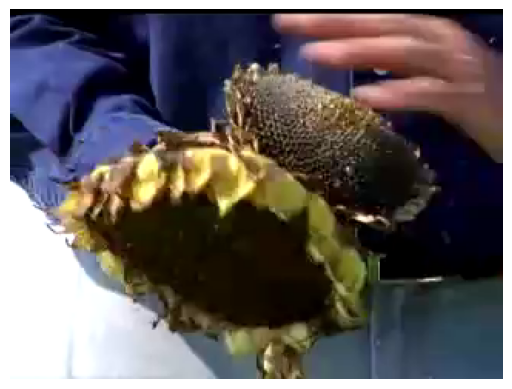


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


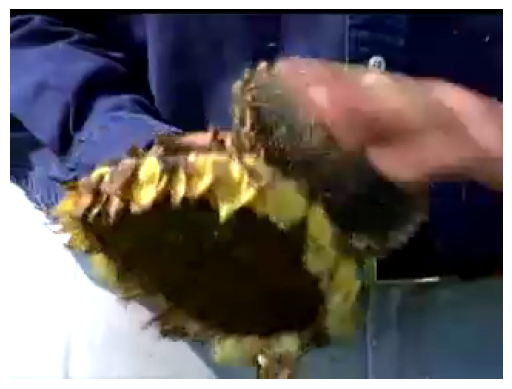


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


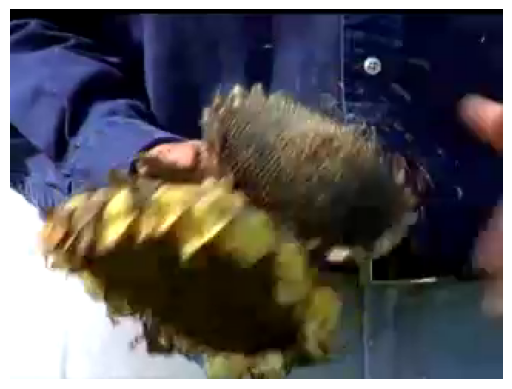


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


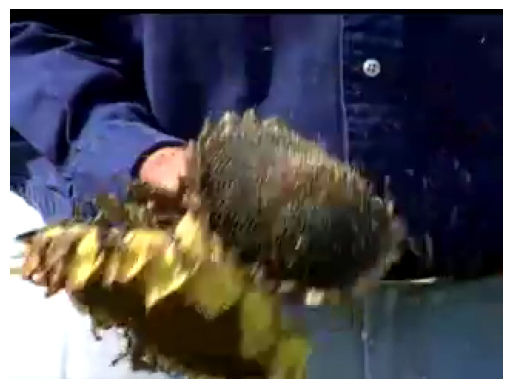


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


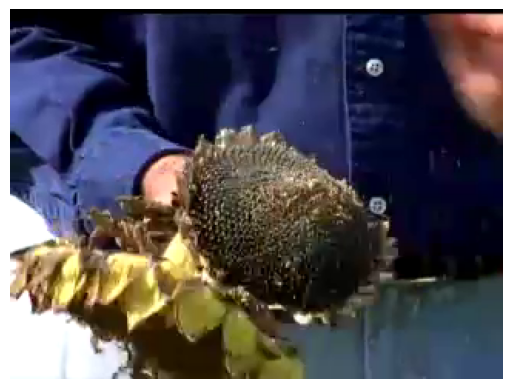


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


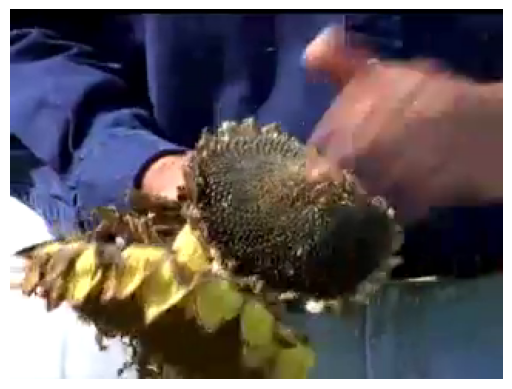


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


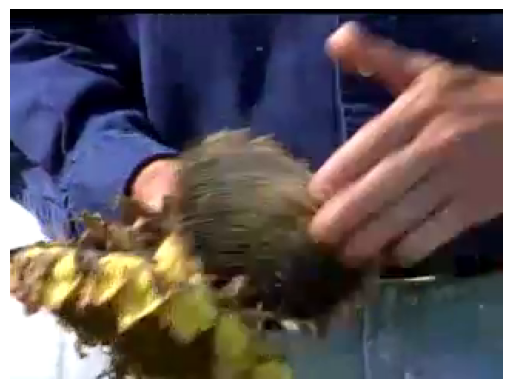


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


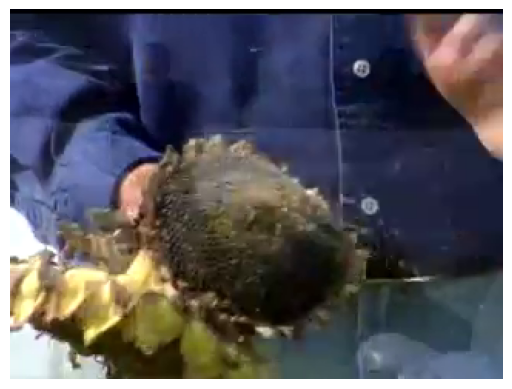


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


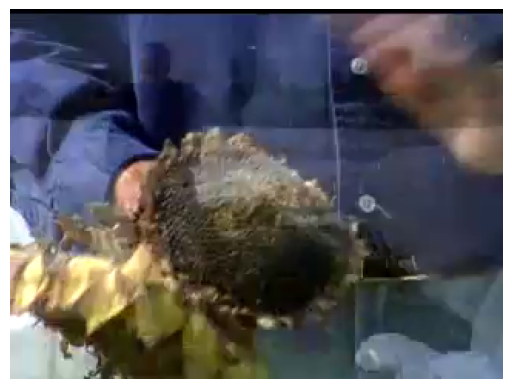


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


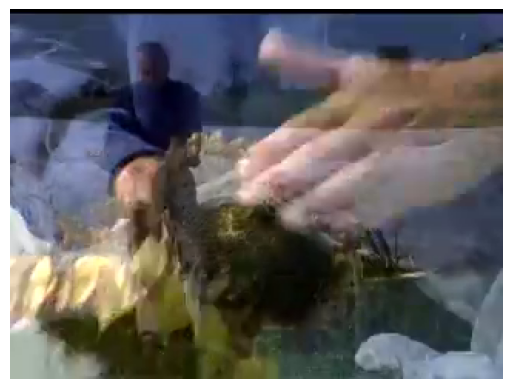


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


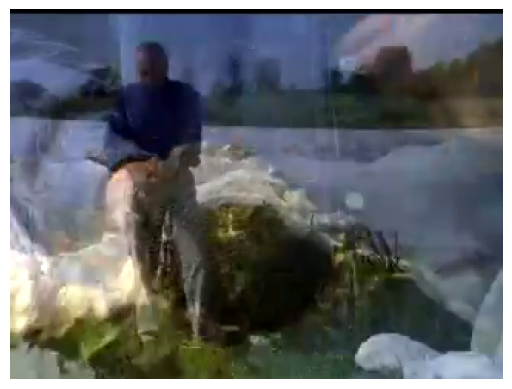


Test Output Captions:
- a man is brushing dirt off the top of a sunflower
- the man is rubbing his hand across the center of the sunflower
- the head of a sunflower is above the table
- a man is picking sunflowers from a garden bed below him
- the man is lifting a sunflower towards his face
- a man is clearing dirt off a sunflower in his right hand
- a man standing beside a field of flowers
- the man holds a sunflower close to the camera


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Path to the .avi video file
video_path = "/kaggle/input/msvd-clips/YouTubeClips/-7KMZQEsJW4_205_208.avi"  # Ensure this path points to your .avi file

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Display each frame with training captions and test captions
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if there are no frames left

        # Convert the frame from BGR (OpenCV format) to RGB (matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Show the frame using matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

        print("\nTest Output Captions:")
        for test_caption in test_captions:
            print(f"- {test_caption}")

        # Limit the number of frames displayed to avoid too much output
        frame_index += 1
        if frame_index > 10:  # Adjust this limit as needed
            break

# Release the video capture object
cap.release()